Here, instead of comparing against manual alignments, structural alignment methods are used as a reference instead.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from deepblast.trainer import LightningAligner
from deepblast.dataset.utils import states2edges
from deepblast.score import alignment_score
from deepblast.dataset.parse_mali import read_mali, read_mali_mammoth
from deepblast.dataset.utils import states2matrix
from deepblast.dataset.utils import state_f, tmstate_f, revstate_f
from deepblast.score import alignment_score_kernel

from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
malidup_root = '../data/structure_benchmarks/malidup'
malisam_root = '../data/structure_benchmarks/malisam'

mammoth_dup_root = '../data/structure_benchmarks/mammoth/malidup'
mammoth_sam_root = '../data/structure_benchmarks/mammoth/malisam'

mali_root = malidup_root
mali_mammoth = mammoth_dup_root
benchmark = 'malidup'

In [7]:
#ckpt_path = '../../deep_blast_training/lightning_logs/version_174156/checkpoints/epoch=6.ckpt'
ckpt_path = '../../deep_blast_training/lightning_logs/version_174137/checkpoints/epoch=9.ckpt'

model = LightningAligner.load_from_checkpoint(ckpt_path).cuda()

In [21]:
# read in manual and Mammoth
mammoth = read_mali_mammoth(mali_mammoth, report_ids=True)
manual = read_mali(mali_root, tool='manual', report_ids=True)
res = pd.merge(manual, mammoth, left_on='dir', right_on='pdb')
res = res[['0_x', '1_x', '2_x', '2_y']]
res = res.rename(columns={'0_x' : 0, '1_x' : 1, '2_x' : 'manual', '2_y': 'mammoth'})
res = res[~res.set_index([0, 1]).index.duplicated(keep='first')]
res = res.set_index([0, 1])

# read in TMalign, Fast and Dali 
fast   = read_mali(mali_root, tool='fast')
tm     = read_mali(mali_root, tool='tm')
dali   = read_mali(mali_root, tool='dali')
fast = fast[~fast.set_index([0, 1]).index.duplicated(keep='first')]
tm = tm[~tm.set_index([0, 1]).index.duplicated(keep='first')]
dali = dali[~dali.set_index([0, 1]).index.duplicated(keep='first')]

# build multi-indexes
tm_ = tm.set_index([0, 1]).rename(columns={2: 'tm'})
fast_ = fast.set_index([0, 1]).rename(columns={2: 'fast'})
dali_ = dali.set_index([0, 1]).rename(columns={2: 'dali'})

# merge together
res = pd.merge(res, fast_, left_index=True, right_index=True)
res = pd.merge(res, tm_, left_index=True, right_index=True)
res = pd.merge(res, dali_, left_index=True, right_index=True)
#res = rename ['fast', 'tm', 'dali']

# Needleman-wunsch and deepblast
dp     = res.reset_index().apply(lambda x: model.align(x[1], x[0]), axis=1)
res['deepblast'] = dp.values

In [22]:
import dask.dataframe as dd

def score_local_identity(x, k, reference):
    if x['query_start'] < 0 :
        return [0.] * len(k)
    else:
        return alignment_score_kernel(x[reference], x['aln'], kernel_widths=k, 
                                      query_offset=x['query_start'],
                                      hit_offset=x['hit_start'])

def score_local_alignment(df, k, n_cores=4):
    df2 = dd.from_pandas(df, npartitions=n_cores)
    func = lambda x: score_local_identity(x, k)
    res = df2.apply(func, axis=1)
    resdf = res.compute(scheduler='processes')
    return pd.DataFrame(list(resdf.values), columns=k)

def score_global_alignment(df, col, k, reference, n_cores=4):
    df2 = dd.from_pandas(df, npartitions=n_cores)
    func = lambda x: alignment_score_kernel(x[reference], x[col], k)
    res = df2.apply(func, axis=1)
    resdf = res.compute(scheduler='processes')
    return pd.DataFrame(list(resdf.values), columns=k)

In [23]:
k = [1, 3, 5, 10]

# Global alignments
dp_tm_ref = score_global_alignment(res.reset_index(), 'deepblast', k, reference='tm', n_cores=30)
dp_fast_ref = score_global_alignment(res.reset_index(), 'deepblast', k, reference='fast', n_cores=30)
dp_dali_ref = score_global_alignment(res.reset_index(), 'deepblast', k, reference='dali', n_cores=30)
dp_mammoth_ref = score_global_alignment(res.reset_index(), 'deepblast', k, reference='mammoth', n_cores=30)

In [25]:
dp_tm_ref['reference'] = 'tm'
dp_fast_ref['reference'] = 'fast'
dp_dali_ref['reference'] = 'dali'
dp_mammoth_ref['reference'] = 'mammoth'

# add additional metadata regarding the pdb files
manual = read_mali(mali_root, tool='manual', report_ids=True)
dp_tm_ref['pdb'] = manual['pdb']
dp_fast_ref['pdb'] = manual['pdb']
dp_dali_ref['pdb'] = manual['pdb']
dp_mammoth_ref['pdb'] = manual['pdb']


# combine stats
data = pd.concat((dp_tm_ref, dp_fast_ref, dp_dali_ref, dp_mammoth_ref))
# save file locally for later
data.to_csv(f'{benchmark}_reference_perc_id.csv')

# melt dataframe to make it easier to plot
data = pd.melt(data, id_vars=['reference', 'pdb'], var_name='kernel_width')

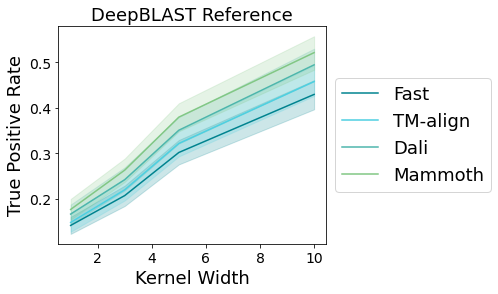

In [31]:
lookup = {'fast' : 'Fast', 'tm' : 'TM-align', 'dali' : 'Dali', 
          'mammoth': 'Mammoth', }

data['Reference'] = data.apply(lambda x: lookup[x['reference']], axis=1)

green = sns.light_palette("seagreen")
purple = sns.dark_palette("blue", reverse=True)
fig, ax = plt.subplots()
palette = {
    'Fast' : '#00838f',
    'TM-align' : '#4dd0e1',
    'Dali' : '#4db6ac',
    'Mammoth' : '#81c784'
}
sns.lineplot(data=data, x='kernel_width', y='value', hue='Reference', ax=ax,
             palette=palette, hue_order=['Fast', 'TM-align', 'Dali', 'Mammoth'])

ax.set_ylabel('Percent Identity')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_xlabel('Kernel Width', fontsize=18)
ax.tick_params(labelsize=14)
ax.set_title('DeepBLAST Reference', fontsize=18)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 18})
fig.savefig(f'{benchmark}-deepblast-reference.png', bbox_inches='tight')

In [64]:
deepblast_tm_ref = score_global_alignment(res.reset_index(), 'deepblast', k, reference='tm', n_cores=30)
mammoth_tm_ref = score_global_alignment(res.reset_index(), 'mammoth', k, reference='tm', n_cores=30)

In [80]:
deepblast_tm_ref['reference'] = 'deepblast'
mammoth_tm_ref['reference'] = 'mammoth'
data = pd.concat((deepblast_tm_ref, mammoth_tm_ref))
data = pd.melt(data, id_vars=['reference'], var_name='kernel_width')

Text(0.5, 1.0, 'TM-align reference')

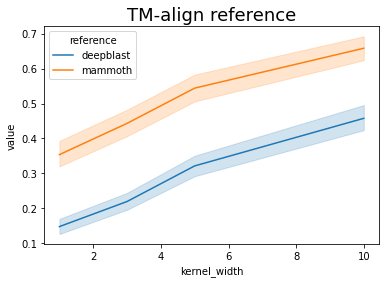

In [81]:
sns.lineplot(data=data, x='kernel_width', y='value', hue='reference')
plt.title('TM-align reference', fontsize=18)

In [83]:
deepblast_fast_ref = score_global_alignment(res.reset_index(), 'deepblast', k, reference='fast', n_cores=30)
mammoth_fast_ref = score_global_alignment(res.reset_index(), 'mammoth', k, reference='fast', n_cores=30)
dali_fast_ref = score_global_alignment(res.reset_index(), 'dali', k, reference='fast', n_cores=30)
tm_fast_ref = score_global_alignment(res.reset_index(), 'tm', k, reference='fast', n_cores=30)

In [86]:
deepblast_fast_ref['reference'] = 'DeepBLAST'
mammoth_fast_ref['reference'] = 'Mammoth'
dali_fast_ref['reference'] = 'Dali'
tm_fast_ref['reference'] = 'TM-align'

data = pd.concat((deepblast_fast_ref, mammoth_fast_ref, dali_fast_ref, tm_fast_ref))
data = pd.melt(data, id_vars=['reference'], var_name='kernel_width')

Text(0.5, 1.0, 'Fast reference')

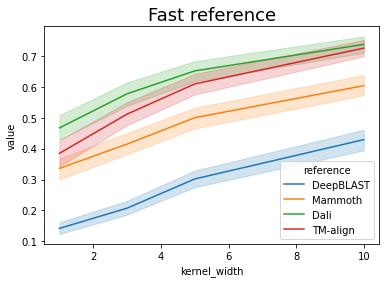

In [87]:
sns.lineplot(data=data, x='kernel_width', y='value', hue='reference')
plt.title('Fast reference', fontsize=18)

Other statistics

In [32]:
columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]

fast_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['deepblast'], x['fast']), axis=1).values), 
                          columns=columns)
tm_stats   = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['deepblast'], x['tm']), axis=1).values), 
                          columns=columns)
dali_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['deepblast'], x['dali']), axis=1).values), 
                          columns=columns)
mam_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['deepblast'], x['mammoth']), axis=1).values), 
                          columns=columns)

In [37]:
fast_stats['tool'] = 'fast'
tm_stats['tool'] = 'tm'
dali_stats['tool'] = 'dali'
mam_stats['tool'] = 'mammoth'
data = pd.concat((fast_stats, tm_stats, dali_stats, mam_stats))
data.to_csv(f'{benchmark}_reference_allstats.csv')
data['precision'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fp']), axis=1)
data['recall'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fn']), axis=1)
data['f1'] = data.apply(lambda x: 2 / ((1 / x['precision']) + (1 / x['recall'])), axis=1)
data = data.dropna()

In [38]:
data

,val_tp,val_fp,val_fn,val_perc_id,val_ppv,val_fnr,val_fdr,tool,precision,recall,f1
0,14,180,140,0.090909,0.072165,0.909091,0.927835,fast,0.072165,0.090909,0.080460
1,8,75,57,0.123077,0.096386,0.876923,0.903614,fast,0.096386,0.123077,0.108108
2,3,144,126,0.023256,0.020408,0.976744,0.979592,fast,0.020408,0.023256,0.021739
3,23,28,21,0.522727,0.450980,0.477273,0.549020,fast,0.450980,0.522727,0.484211
4,7,351,283,0.024138,0.019553,0.975862,0.980447,fast,0.019553,0.024138,0.021605
...,...,...,...,...,...,...,...,...,...,...,...
229,2,70,80,0.024390,0.027778,0.975610,0.972222,mammoth,0.027778,0.024390,0.025974
230,13,176,211,0.058036,0.068783,0.941964,0.931217,mammoth,0.068783,0.058036,0.062954
231,26,36,40,0.393939,0.419355,0.606061,0.580645,mammoth,0.419355,0.393939,0.406250
232,2,148,172,0.011494,0.013333,0.988506,0.986667,mammoth,0.013333,0.011494,0.012346


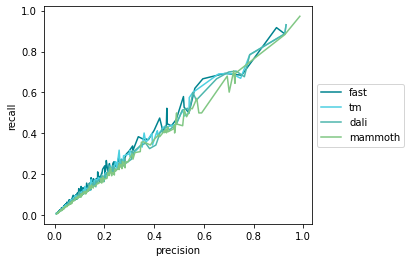

In [42]:
green = sns.light_palette("seagreen")
purple = sns.dark_palette("blue", reverse=True)
fig, ax = plt.subplots()
palette = {
    'fast' : '#00838f',
    'tm' : '#4dd0e1',
    'dali' : '#4db6ac',
    'mammoth' : '#81c784',
}
#sns.lineplot(data=data, x='precision', y='recall', hue='tool', ax=ax,
#             palette=palette, hue_order=['fast', 'tm', 'dali', 'mammoth'])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [54]:
data

,val_tp,val_fp,val_fn,val_perc_id,val_ppv,val_fnr,val_fdr,tool,precision,recall,f1
0,14,180,140,0.090909,0.072165,0.909091,0.927835,fast,0.072165,0.090909,0.080460
1,8,75,57,0.123077,0.096386,0.876923,0.903614,fast,0.096386,0.123077,0.108108
2,3,144,126,0.023256,0.020408,0.976744,0.979592,fast,0.020408,0.023256,0.021739
3,23,28,21,0.522727,0.450980,0.477273,0.549020,fast,0.450980,0.522727,0.484211
4,7,351,283,0.024138,0.019553,0.975862,0.980447,fast,0.019553,0.024138,0.021605
...,...,...,...,...,...,...,...,...,...,...,...
229,2,70,80,0.024390,0.027778,0.975610,0.972222,mammoth,0.027778,0.024390,0.025974
230,13,176,211,0.058036,0.068783,0.941964,0.931217,mammoth,0.068783,0.058036,0.062954
231,26,36,40,0.393939,0.419355,0.606061,0.580645,mammoth,0.419355,0.393939,0.406250
232,2,148,172,0.011494,0.013333,0.988506,0.986667,mammoth,0.013333,0.011494,0.012346


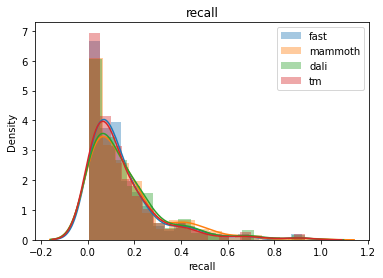

In [62]:
metric = 'recall'
sns.distplot(data.loc[data.tool=='fast', metric], label='fast')
sns.distplot(data.loc[data.tool=='mammoth', metric], label='mammoth')
sns.distplot(data.loc[data.tool=='dali', metric], label='dali')
sns.distplot(data.loc[data.tool=='tm', metric], label='tm')
plt.title(metric)
plt.legend()

In [39]:
print(data.groupby(['tool']).mean()['f1'].to_latex())

\begin{tabular}{lr}
\toprule
{} &        f1 \\
tool    &           \\
\midrule
dali    &  0.162729 \\
fast    &  0.144782 \\
mammoth &  0.171942 \\
tm      &  0.147255 \\
\bottomrule
\end{tabular}



In [40]:
print(data.groupby(['tool']).mean()['precision'].to_latex())

\begin{tabular}{lr}
\toprule
{} &  precision \\
tool    &            \\
\midrule
dali    &   0.166517 \\
fast    &   0.141615 \\
mammoth &   0.179421 \\
tm      &   0.148133 \\
\bottomrule
\end{tabular}



In [41]:
print(data.groupby(['tool']).mean()['recall'].to_latex())

\begin{tabular}{lr}
\toprule
{} &    recall \\
tool    &           \\
\midrule
dali    &  0.159366 \\
fast    &  0.148646 \\
mammoth &  0.165280 \\
tm      &  0.146704 \\
\bottomrule
\end{tabular}

